### Example: Computing prior covariance from model data (what do we know about data variability?)
Part of ESE 156 Remote Sensing Class;
Christian Frankenberg
__________
The purpose of this exercise is to read in model data and generate covariance yourself, which could be fed into the $S_a$ matrix for the retrieval.


In [2]:
## Make sure plots are create inline
%matplotlib inline
## The usual packages (numpy, matplotlib, etc)
from RSE_style import *
figsize(10,8)

from mpl_toolkits.basemap import Basemap

from netCDF4 import Dataset
from netCDF4 import MFDataset
#from netCDF4 import netcdftime
from netCDF4 import num2date

In [27]:
# This is actually very convenient as it can read in multiple files at once 
# (needed to convert the files to adhere to the classic filesystem before)
# For global data, get wget ftp://aftp.cmdl.noaa.gov/products/carbontracker/co2/molefractions/co2_total/CT2017.molefrac_glb3x2_2016-06*
d = MFDataset("files/CT2016.molefrac_nam1x1_*.nc4","r")

In [5]:
co2= d.variables["co2"][:]
lat = d.variables["latitude"][:]
lon = d.variables["longitude"][:]
p = d.variables["pressure"][:]
gph = d.variables["gph"][:]

nctime = d.variables["time"][:]
t_unit = d.variables["time"].units # get unit  "days since 1950-01-01T00:00:00Z"
print(t_unit)

try :
    t_cal = d.variables["time"].calendar
except AttributeError : # Attribute doesn't exist
    t_cal = u"gregorian" # or standard
datevar = []
datevar.append(num2date(nctime,units = t_unit,calendar = t_cal))


days since 2000-01-01 00:00:00 UTC


Text(0.5, 1.0, 'Correlation Matrix')

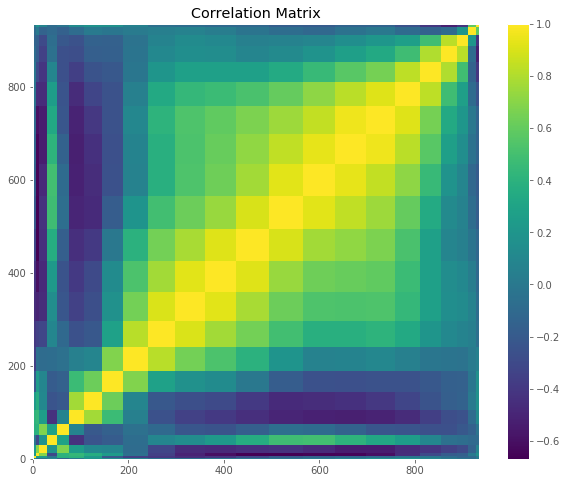

In [50]:
# Choosing Caltech here again 34.1377° N, 118.1253W
lat_ = 34.1377
lon_ = -118.1253
#lat_ = 40
#lon_ = -88

figsize(10,8)
iLat =np.argmin(np.abs(lat-lat_))
iLon =np.argmin(np.abs(lon-lon_))
pL = p[4,:,iLat,iLon]
p_c = (pL[1:]+pL[0:-1])/200.
p_c.shape
co2_lamont = co2[:,:,iLat,iLon]
S_co2 = np.cov(co2_lamont.T)
Corr_co2 = np.corrcoef(co2_lamont.T)
S_co2.shape
plt.pcolor(p_c, p_c,Corr_co2,cmap='viridis')
plt.colorbar()
plt.title('Correlation Matrix')


Can you guess where the anti-correlations come from at 180hPa?

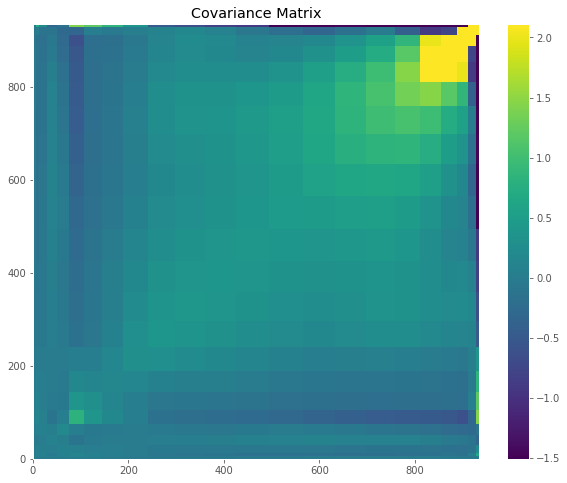

In [51]:
figsize(10,8)
plt.pcolor(p_c, p_c,S_co2,cmap='viridis')
plt.colorbar()
plt.title('Covariance Matrix')
plt.clim((np.percentile(S_co2,2),np.percentile(S_co2,98)))

This is now an actual data-driven covarianc matrix, which could be used for real retrievals (maybe after removing night-time data as we are mainly interested in day-time covariance structure). I changed the color-scale to make other regions more clear, otherwise, the boundary layer will dominate the structure.

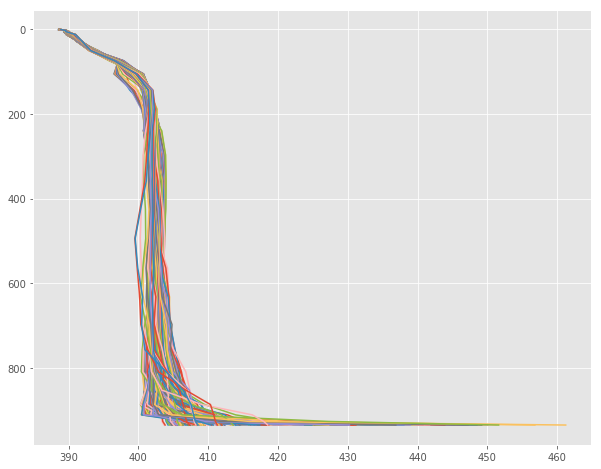

In [52]:
plt.plot(co2[:,:,iLat,iLon].T,p_c)
plt.gca().invert_yaxis()

In [53]:
dat = datevar[0]

Let us now compute XCO2 (ignoring H2O for now, has a small impact):

In [54]:
d = co2.shape
xco2 = np.zeros((240,d[2],d[3]))
for i in range(240):
    for iLat2 in range(d[2]):
        for iLon2 in range(d[3]):
            dp = p[i,0:-1,iLat2,iLon2]-p[i,1:,iLat2,iLon2]
            h = dp/np.sum(dp)
            xco2[i,iLat2,iLon2]= h.T.dot(co2[i,:,iLat2,iLon2])



Plotting XCO$_2$ timeseries (top) as well as CO$_2$ at different layers in the bottom

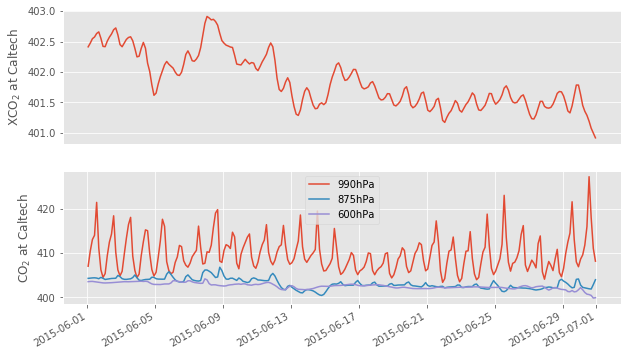

In [55]:
#print p[1,0:-1,iLat2,iLon2]
figsize(10,6)
plt.subplot(211)
plt.plot(dat,xco2[:,iLat,iLon])
plt.gca().axes.get_xaxis().set_visible(False)
plt.ylabel('XCO$_2$ at Caltech')
plt.subplot(212)
plt.plot(dat,co2[:,1,iLat,iLon],label='990hPa')
plt.plot(dat,co2[:,5,iLat,iLon],label='875hPa')
plt.plot(dat,co2[:,9,iLat,iLon],label='600hPa')
plt.legend(loc=0)
plt.gcf().autofmt_xdate()
plt.ylabel('CO$_2$ at Caltech')
plt.savefig('XCO2_timeSeries.pdf')

Plotting time-series of XCO2 as maps:

22.5 61.5 -128.5 -63.5


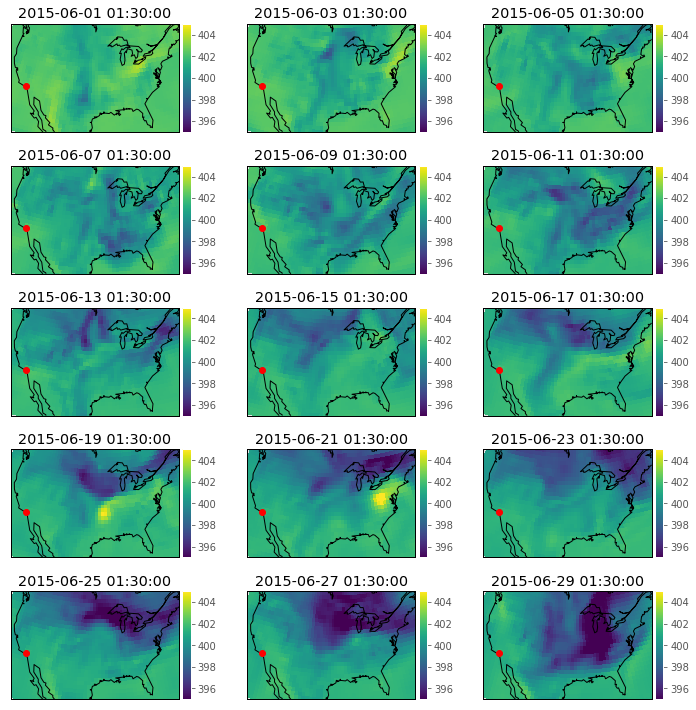

In [56]:
figsize(10,10)
fig = plt.figure()
# Plot one example on the globe (surface pressure in hPa)
print(lat[0], lat[-1], lon[0],lon[-1])
# convert the lat/lon values to x/y projections.
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

x, y = m(*np.meshgrid(lon,lat))
x2, y2 = m(*np.meshgrid(lon_,lat_))

for i in range(15):
    fig.add_subplot(5,3,i+1)
    m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
    m.pcolormesh(x,y,xco2[i*16,:,:],shading='flat',cmap=plt.cm.viridis, vmin=395, vmax=405)
    m.colorbar(location='right')
    plt.title(str(dat[i*16]))
    m.drawcoastlines()
    m.drawmapboundary()
    m.plot(x2, y2, 'ro')
plt.tight_layout()
plt.savefig('XCO2_maps.pdf')